In [1]:
import nibabel as nb
import numpy as np
import nilearn.plotting as nlp
from nilearn_plotting_custom import plot_surf
import hcp_utils as hcp
from hcp_tools import extract_cortex
from hcp_tools import load_meshes
from analysis import load_data
from hcp_tools import load_flatmaps_59k
from analysis import simple_ridgeCV
from analysis import plot_59k_results
import os
import hrf_tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("paper", "white")
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
from os import walk
import nibabel as nb
import numpy as np
import pandas as pd

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
subject=100610
feature='rms'
n_movies=4

In [4]:
def load_data(subject,feature,n_movies):
    from sklearn.preprocessing import StandardScaler
    # Inputs: subject = HCP id eg 100610
    #         feature='mfs'
    #         n_movies is a number 1-4
    # Returns: X feature data (2D; time x feature)
    #          Y brain data (2D; time x grayordinate)
    scaler = StandardScaler()
    y_l=[]
    x_l=[]
    stim = ['tfMRI_MOVIE1_7T_AP','tfMRI_MOVIE2_7T_PA','tfMRI_MOVIE3_7T_PA','tfMRI_MOVIE4_7T_AP']
    stim_feat = ['7T_MOVIE1_CC1_v2', '7T_MOVIE2_HO1_v2', '7T_MOVIE3_CC2_v2', '7T_MOVIE4_HO2_v2']
    
    for i in np.arange(n_movies):
        #load brain image
        im_file = f'../sourcedata/data/HCP_7T_movie_FIX/brain/HCP_7T_movie_FIX/{str(subject)}/MNINonLinear/Results/{stim[i]}/{stim[i]}_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
        img = nb.load(im_file)
        img_y = img.get_fdata()
        img_y = scaler.fit_transform(img_y)
        #load feature
        feat_x = np.load(f'../sourcedata/data/HCP_7T_movie_FIX/features/{stim_feat[i]}_{feature}.npy')
        feat_x = hrf_tools.apply_optimal_hrf_10hz(feat_x,10)
        feat_x = hrf_tools.resample_1hz(feat_x)
        feat_x = feat_x[:img_y.shape[0],:]
        #feat_x=feat_x.T
        y_l.append(img_y)
        x_l.append(feat_x)
    Y=np.vstack(y_l)
    X=np.vstack(x_l)
    X = scaler.fit_transform(X)
    vertex_info = hcp.get_HCP_vertex_info(img)
    return X,Y,vertex_info

In [5]:
X,Y,vertex_info = load_data(subject,feature,n_movies)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [6]:
X.shape

(3655, 1)

In [7]:
Y.shape

(3655, 170494)

In [8]:
tr=1
n_scans=X.shape[0]

In [10]:
events = pd.DataFrame(columns=['trial_type', 'onset',
                       'duration'])

In [11]:
for i in np.arange(n_scans):
    c_title = 'c'+str(i)
    conditions = [c_title] * n_scans
    duration = np.ones(n_scans)+0.5
    onsets = np.arange(0,n_scans,1)
    df= pd.DataFrame({'trial_type': conditions, 'onset': onsets, 'duration': duration})
    #print(df)
    events.append(df)

In [9]:
frame_times= np.arange(n_scans)


In [16]:
from nilearn.glm.first_level import make_first_level_design_matrix
design_matrices = make_first_level_design_matrix(frame_times, None,
                          add_regs= X, hrf_model='spm', drift_model=None)

In [18]:
design_matrices

,reg0,constant
0,-1.044246,1.0
1,-1.044246,1.0
2,-1.044246,1.0
3,-1.044246,1.0
4,-1.044246,1.0
...,...,...
3650,-1.455334,1.0
3651,-1.435397,1.0
3652,-1.403661,1.0
3653,-1.364386,1.0


<AxesSubplot:label='conditions', ylabel='scan number'>

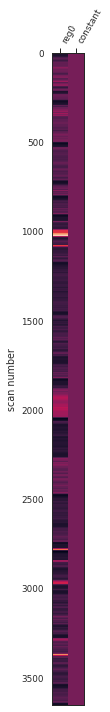

In [19]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrices)

In [21]:
from nilearn.glm.first_level import run_glm
fmri_glm_labels,fmri_glm_results = run_glm(Y,design_matrices.values)

In [27]:
from nilearn.glm.contrasts import compute_contrast
contrast = compute_contrast(fmri_glm_labels, fmri_glm_results, np.array([1,0]),contrast_type='t')

In [33]:
contrast.z_score()
contrast.p_value()
contrast.effect_size()

<bound method Contrast.effect_size of <nilearn.glm.contrasts.Contrast object at 0x2b605ca5e3a0>>